In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability_v2, get_mPE_matrix, get_vel_matrix
from sklearn.cluster import KMeans

In [8]:
rats = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150_ordered.npy')
lengths = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy')

to_be_removed = '.ipynb_checkpoints'

root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
normal_trajs = os.listdir(root_dir + 'normal')
drug_trajs_1 = os.listdir(root_dir + 'caffeine')
drug_trajs_2 = os.listdir(root_dir + 'amphetamine')


if to_be_removed in normal_trajs:
    idx = normal_trajs.index(to_be_removed)
    normal_trajs.pop(idx)
    normal_trajs.sort()

    
if to_be_removed in drug_trajs_1:
    idx = drug_trajs_1.index(to_be_removed)
    drug_trajs_1.pop(idx)
    drug_trajs_1.sort()

if to_be_removed in drug_trajs_2:
    idx = drug_trajs_2.index(to_be_removed)
    drug_trajs_2.pop(idx)
    drug_trajs_2.sort()

names = normal_trajs + drug_trajs_1 + drug_trajs_2

print(names)

['traj_1', 'traj_2', 'traj_3', 'traj_5', 'traj_8', 'traj_4', 'traj_2', 'traj_6', 'traj_5', 'traj_3', 'traj_7', 'traj_1']


In [9]:
def mPE__(*argv):    
    g=len(argv)
    
    if g==2:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=np.array([1])
    if g==3:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=argv[2]
    if g==4:
        n=argv[1]
        datain=argv[0]
        lamin=argv[3]
        epsin=argv[2]
    
#    Check for the data to be in the right dimension        
    if datain.shape[0] == 1 or datain.shape[1] == 1:
        if len(datain[:,0])>len(datain[0,:]):
            datain=datain.transpose()
    else:
        if len(datain[:,1])>len(datain[1,:]):
            datain=datain.transpose()
        
    scalesno=len(epsin)
    lagno=len(lamin)
    HH=np.zeros((lagno,scalesno))
    norm_HH=np.zeros((lagno,scalesno))
#    Definition of parameters: fac is the number of possible permutations
#    Elem is the No of data points
#    Dim is the dimensionality of the samples
    
    for lam in range(0,lagno):
        for eps in range(0,scalesno):
            scale=epsin[eps]
            L=lamin[lam]
            xlen=len(datain[0,:])
            ylen=np.round((xlen/scale)-0.5)
            ylen=ylen.astype(int)
            D=np.zeros((len(datain[:,0]),ylen))
            for ylenc in range(0,ylen):
                dfg=datain[:,((ylenc)*scale):((ylenc+1)*scale)]
                fhk=np.sum(dfg,axis=1)
                r=(1/scale)*fhk
                D[:,ylenc]=r
                
            data=D
            fac=mt.factorial(n)
            elem=len(data[0,:])
            dim=len(data[:,0])
            
        #    A is a n-by-factorial(n) matrix that shows all the 
        #    possible permutations of n elements
            A=permutation(n)
            
        #    counter is a factorial(n) square matrix that counts the recurrence of
        #    a dim-dimensional permutation
            lpi=fac*np.ones((dim))
            lpi=lpi.astype(int)
            nj = lpi.tolist()
            counter=np.zeros((nj))
            
        #    For each iteration i, a series of n points is sampled from the 
        #    data set and the corresponding permutation is identified. 
        #    The counter matrix keeps track of the numiber of times a certain
        #    permutation, or combination of permutations is observed. 
            for i in range(0, elem-n*L+L-1):
                coord=np.zeros((dim))
                for num in range(0,dim):
                    sample=data[num,range(i,i+L*(n),L)]
                    ord=ubble(sample)
                    perm_num=0
                    check_1=1
                    check_2=1
                    
                    while (perm_num<=fac) and (check_2):
                       
                        check_1=1
                        for j in range(0,n-1):
                            if ord[j]!=A[perm_num,j]:
                                check_1=0
                        if check_1:
                            coord[num]=perm_num
                            check_2=0
                            
                        perm_num=perm_num+1
                
                    
                coord=coord.astype(int)
                coord1=tuple(coord)
                counter[coord1]=counter[coord1]+1
                
        #    Once the counter matrix is complete, each element is divided by the
        #    total number of samples to get a empirical probability, and the PE is
        #    computed according to the method described in Schurmann
            
            H=0
            counter1=counter.flatten()
            for iter in range(0,(fac**dim)):
               
                rec=counter1[iter]
                tot=elem-n+1
                
                if rec==0:
                    H=H
                    
                else:
                    I = quad(integrand, 0, 1, args=(rec))
                    I=I[0]
                    coeff=((-1)**rec)*I
                    prob=(rec/tot)*(psi.digamma(tot)-psi.digamma(rec)-coeff)
                    H=H+mt.log2(mt.exp(prob))
                 
        #     The normalised entropy norm_H is computed as well
            norm_H=H/(mt.log2(fac**dim))
            
            HH[lam,eps]=H
            norm_HH[lam,eps]=norm_H
    return [HH,norm_HH]

In [10]:
def get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random):
    if random:
        bins_number = 2
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        print(mPE_vector.shape)

        for i in range(bins_number):
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                traj = reduced_traj[idx_1: idx_1 + traj_length]
                [HH, _]=mPE__(traj, orders[0])
                mPE_vector[i, idx, 0] = HH
                idx +=1

    else:
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        
        for a, order in enumerate(orders):
            
            for i in range(bins_number):
                idx = 0
                
                for j in range(0, traj_length*traj_number, traj_length):
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                        
                    if traj.shape[0]>0:
                        [HH, _]=mPE__(traj, order)
                        mPE_vector[i, idx, a] = HH
                        
                    idx +=1
    
    return mPE_vector

In [11]:
def get_vel_matrix_(trajectory, bins_number, traj_number, orders, random=False, least_varaince_zdim=0):
    
    if random:
        bins_number = 2
        vel_matrix = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((trajectory.shape[0]/bins_number)/traj_number)
        
        print(vel_matrix.shape)

        for i in range(bins_number):
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = np.random.randint(np.max(trajectory.shape) - traj_length)
                traj = trajectory[idx_1: idx_1 + traj_length]
                traj = np.asarray(traj)
                vel_bin = 0
                last_point = traj[0, :]

                for point in traj:
                    vel_bin = vel_bin + distance.euclidean(point, last_point)
                    last_point = point
                
                vel_matrix[i, idx, 0] = vel_bin/(traj_length)
                idx += 1
        
        mPE_vector = []
        
    else:
        if trajectory.shape[0] < trajectory.shape[1]:
            trajectory =  trajectory.transpose()

        dims = 2

        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        vel_matrix = np.zeros((bins_number, traj_number, len(orders)))

        traj_length = int((trajectory.shape[0]/bins_number)/traj_number)

        for a, order in enumerate(orders):

            for i in range(bins_number):

                idx = 0
                idx_1 = 0

                for j in range(0, traj_length*traj_number, traj_length):

                    idx_1 = i*traj_number*traj_length 
                    traj = trajectory[idx_1 + j: idx_1 + j + traj_length, :]
                    traj = np.asarray(traj)
                    vel_bin = 0
                    last_point = traj[0, :]

                    for point in traj:
                        vel_bin = vel_bin + distance.euclidean(point, last_point)
                        last_point = point

                    if traj.shape[0]>0:
                        [HH, _] = mPE_(traj, order)
                        mPE_vector[i, idx] = HH

                    vel_matrix[i, idx, a] = vel_bin/(traj_length)

                    idx += 1
                
    return mPE_vector, vel_matrix

In [12]:
def get_PCA_matrix_(reduced_traj, bins_number, traj_number, orders, n_PC=3):

    pca_3PCs = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)

    for a, order in enumerate(orders):

        for i in range(bins_number):
            idx = 0

            for j in range(0, traj_length*traj_number, traj_length):
                
                idx_1 = i*traj_number*traj_length 
                traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]

                pca = PCA(n_components=n_PC)
                traj = pca.fit_transform(traj)
                exp_var = np.sum(pca.explained_variance_ratio_[0:3])

                if traj.shape[0]>0:
                    pca_3PCs[i, idx, a] = exp_var

                idx +=1
    
    return pca_3PCs

(820800, 3)
(1695600, 3)
(2894400, 3)
(3942000, 3)


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposi

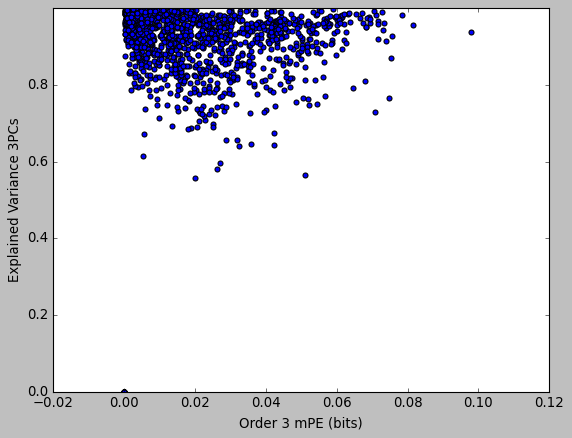

(334800, 3)
(669600, 3)
(1004400, 3)
(1339200, 3)


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposi

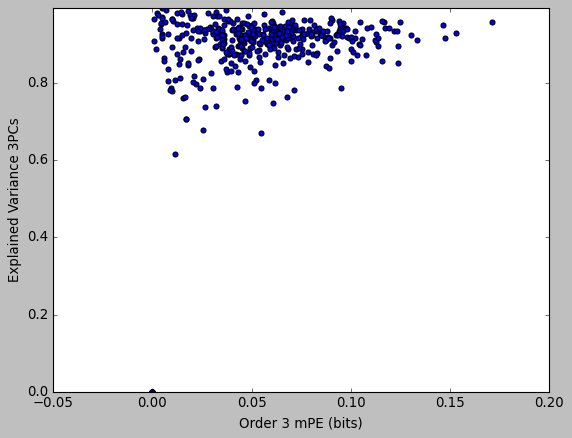

(334800, 3)
(529200, 3)
(864000, 3)
(1198800, 3)


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/sklearn/decomposi

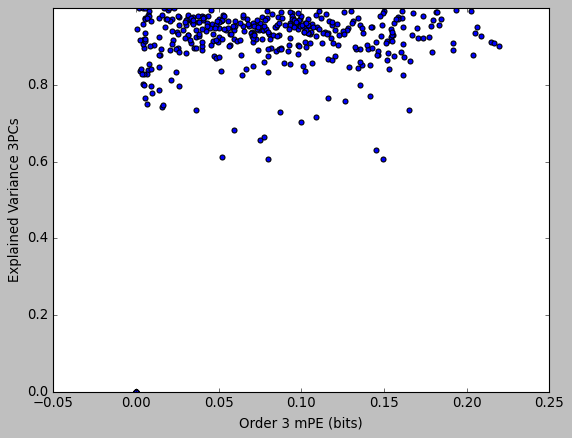

In [13]:
###################################################################################################################################################
############################################################ Velocity vs Entropy ##################################################################
###################################################################################################################################################

block_lengths = [sum(lengths[0:(i*4)+4]) for i in range(3)]
cum_lengths = [sum(lengths[0:i+1]) for i in range(1, len(lengths)+1)]

PCs = [3]
modes = ['normal', 'caffeine', 'amphetamine']
idx = 0

########### TUNE #############
use_all = True 
use_partition_up = False
use_partition_down = False 
use_single = False 
##############################

if use_single:
    nPCs = [3]
    dims = np.arange(9,12)
    use_PCA = False
    add_on = 'marker'

if use_partition_up:
    nPCs = [3]
    dims_1 = np.arange(24)
    dims_2 = np.arange(36,42)
    use_PCA = True
    add_on = 'partition_up'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)

if use_partition_down:
    nPCs = [3]
    dims_1 = np.arange(24,36)
    dims_2 = np.arange(42,60)
    use_PCA = True
    add_on = 'partition_down'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)
    
if use_all:
    dims = np.arange(60)
    use_PCA = True
    add_on = 'all'

count = 0

for n_PC in PCs:
    
    for which_traj, length in enumerate(lengths):
    
        ################ retireving single trajectory ################
        if which_traj == 0:
            idx = 0
        else:
            idx += lengths[which_traj-1]
        
        traj = rats[idx:idx+length, dims]
        
        ################ apply PCA (if necessary) ################
        if use_PCA:
            pca = PCA(n_components=n_PC)
            reduced_traj = pca.fit_transform(traj)
        else:
            reduced_traj = traj
        
        ################ construct dimensionally reduced sequence of trajs ################
        if which_traj%4 == 0:
            rats_reduced = reduced_traj
        else:
            rats_reduced = np.concatenate((rats_reduced, reduced_traj), axis=0)

        print(rats_reduced.shape)
        
        ################ proceed for the analysis if all trajectories of a mode are collected ################
        if (which_traj+1)%4 == 0:
            
            if count == 0:
                non_reduced_traj = rats[0: block_lengths[0], dims]
            else:
                non_reduced_traj = rats[block_lengths[count-1]: block_lengths[count], dims]

            unit_length = 3000
            fs = 30
            minutes = 30
            bin_length = fs*60*minutes
            traj_number = int(bin_length/unit_length)
            bins_number = int(rats_reduced.shape[0]/bin_length)
            order = [3]
            
            ################ calculate mPE and PCA for each trajectory block ################
            _, mPE_vector = get_vel_matrix_(rats_reduced, bins_number, traj_number, order, random=False)
            PCA_explained_var = get_PCA_matrix_(non_reduced_traj, bins_number, traj_number, order)
            
            PCA_explained_var = np.nan_to_num(PCA_explained_var)
            
            path_out_1 = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/RESULTS/pca_vs_mPE/mPE_vector_' + str(add_on) + '_' + str(modes[count]) + '.npy'
            path_out_2 = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/RESULTS/pca_vs_mPE/explained_var_' + str(add_on) + '_' + str(modes[count]) +'.npy'
            
            # np.save(path_out_1, mPE_vector)
            # np.save(path_out_2, PCA_explained_var)
            
            ################ plotting bin-PCA against corresponding mPE and polynomial fit ################
            PCA_explained_var = PCA_explained_var.flatten()
            mPE_vector_ = mPE_vector.flatten()

            # p = np.polyfit(mPE_vector_, PCA_explained_var, 2)

            if order[0] == 3:
                x_new = np.linspace(4,5.8,200)
            else:
                x_new = np.linspace(6,9.2,200)

            # ffit = np.polyval(p, x_new)

            fig = plt.figure()

            plt.scatter(mPE_vector_, PCA_explained_var)
            # plt.plot(x_new, ffit)

            plt.xlabel('Order ' + str(order[0]) + ' mPE (bits)')
            plt.ylabel('Explained Variance 3PCs')
            plt.ylim([0, np.max(PCA_explained_var)])

            path_out_ = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/RESULTS/pca_vs_mPE/mPE_vs_PCA_' + str(add_on) + '_' + str(modes[count]) + '.png'
            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/RESULTS/pca_vs_mPE/mPE_vs_PCA_' + str(add_on) + '_' + str(modes[count]) + '.eps'
            
            # plt.savefig(path_out_)
            # plt.savefig(path_out)
            plt.show()
            
            count += 1

(array([], dtype=int64),)


(array([ 11.,   0.,   0.,   0.,   0.,   4.,  14.,  80., 287., 918.]),
 array([0.        , 0.09999973, 0.19999945, 0.29999918, 0.3999989 ,
        0.49999863, 0.59999835, 0.69999808, 0.79999781, 0.89999753,
        0.99999726]),
 <BarContainer object of 10 artists>)

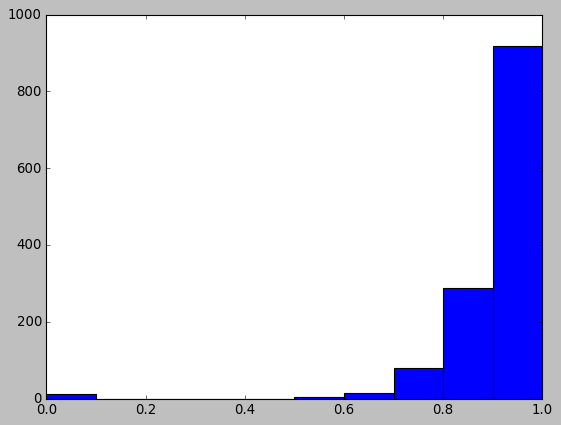

In [32]:
print(np.where(PCA_explained_var==np.max(PCA_explained_var)))
plt.hist(np.nan_to_num(PCA_explained_var))

In [29]:
np.count_nonzero(~np.isnan(PCA_explained_var))

1303